In this notebook we will download & open a geotiff, extract a region using a geojson reference area of interest, and show some basic operations using the image data. The geojson is included in this repository but the image must be first downloaded as it is too large to keep on Github. The geotiff is a high-resolution 4-chanel NAIP imagery from Redmond, WA and the  GeoJSON file consisting of 68 polygon labels. The labels contain three classes: "building", "water", and "other"

A note on coordinate reference systems (CRS): it is necessary to check these and ensure all images, polygons etc are in a single CRS 

### References
- Source of image & label: https://github.com/microsoft/satellite-imagery-labeling-tool/blob/main/example/training-example.ipynb
- Rasterio quickstart: https://rasterio.readthedocs.io/en/latest/quickstart.html

In [27]:
## first download the image - we only need to do this once so it is commented out

# import urllib.request
# urllib.request.urlretrieve("https://naipeuwest.blob.core.windows.net/naip/v002/wa/2019/wa_60cm_2019/47122/m_4712224_sw_10_060_20191011.tif", "example.tif")

In [28]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import show
import rasterio.mask

In [29]:
dataset = rasterio.open('example.tif')

View the file metadata - we see this is 4 channel data. You could also open this image in [QGIS](https://www.qgis.org/en/site/)

In [30]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 8630,
 'height': 12340,
 'count': 4,
 'crs': CRS.from_epsg(26910),
 'transform': Affine(0.6, 0.0, 565464.0,
        0.0, -0.6, 5282196.0)}

Visualise the image

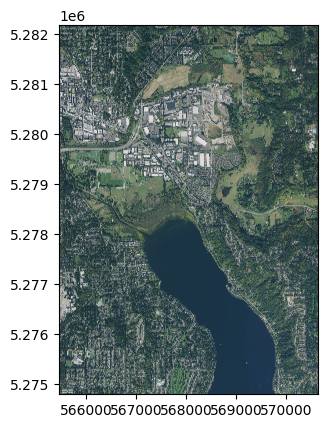

<AxesSubplot: >

In [31]:
show(dataset)

Access the image data using numpy - as it is 4 channel image lets read only the 4th channel as an example

In [32]:
band4 = dataset.read(4)

type(band4)

numpy.ndarray

Use rasterio to show this array

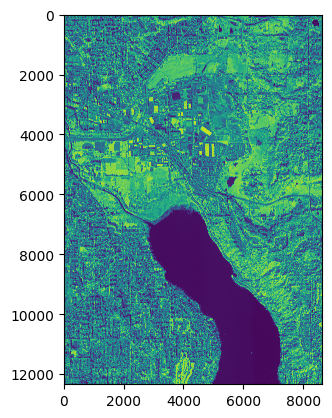

In [33]:
show(band4);

You can also use numpy to calculate some stats of the image if you wished

In [34]:
np.mean(band4)

108.98320388340397

However most likely you only want to access parts of the image. 

We will use geojson to locate the parts of the image we want to analyse. 

I typically use geopandas to view geojson. 

Note the conversion to the same CRS as the geotiff

In [35]:
gdf = gpd.read_file('example_labels.geojson')
gdf.to_crs(crs = dataset.crs, inplace = True)
gdf.head()

,source,class,task_name,geometry
0,Drawn|naip,building,test_0,"POLYGON ((567323.598 5279198.045, 567438.320 5..."
1,Drawn|naip,building,test_0,"POLYGON ((567161.203 5279306.544, 567229.675 5..."
2,Drawn|naip,building,test_0,"POLYGON ((567247.769 5279307.543, 567269.917 5..."
3,Drawn|naip,building,test_0,"POLYGON ((567296.096 5279310.103, 567320.271 5..."
4,OSMOverpass,building,test_0,"POLYGON ((567106.134 5279263.559, 567105.646 5..."


This is a geopandas dataframe so we can use operations familiar to us from pandas to query the data. Lets get the number of polygons for each class

In [36]:
gdf.groupby('class').count()['geometry']

class
building    45
other       17
water        6
Name: geometry, dtype: int64

Geopandas makes it easy to visualise the polygons - lets just plot buildings from now on

<AxesSubplot: >

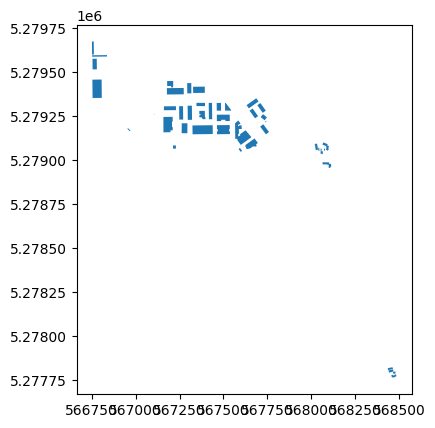

In [37]:
gdf = gdf[gdf['class'] == 'building']
gdf.plot()

Get the largest building - create a column for the polygon area

In [38]:
gdf['area'] = gdf.geometry.area;

Soft by the area, with the largest first

In [39]:
gdf = gdf.sort_values(by='area', ascending = False)
gdf.head()

,source,class,task_name,geometry,area
23,OSMOverpass,building,test_0,"POLYGON ((567583.979 5279226.518, 567565.847 5...",5804.233879
0,Drawn|naip,building,test_0,"POLYGON ((567323.598 5279198.045, 567438.320 5...",5763.772316
48,Drawn|Azure Maps Satellite,building,test_0,"POLYGON ((566755.857 5279354.121, 566808.187 5...",5461.661749
11,OSMOverpass,building,test_0,"POLYGON ((567158.295 5279246.265, 567158.702 5...",4345.665551
14,OSMOverpass,building,test_0,"POLYGON ((567462.721 5279199.657, 567462.673 5...",3649.902775


Now lets get the geometry for the largest single building in order to display the building

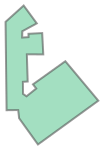

In [40]:
gdf.iloc[0].geometry

This is a shapely Polygon

In [41]:
type(gdf.iloc[0].geometry)

shapely.geometry.polygon.Polygon

We will now use `rasterio.mask.mask` to get the pixels for this geometry:

- https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

In [42]:
shapes = [gdf.iloc[0].geometry] # A list of geometries is required, we pass only one
out_data, out_meta = rasterio.mask.mask(dataset, shapes, crop = True, nodata = 0.0)

We can now view the single building

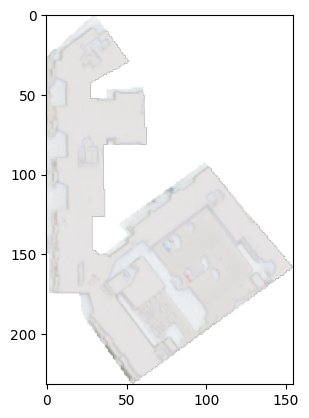

In [43]:
show(out_data);

The returned data is a numpy array

In [44]:
print(type(out_data))
out_data.shape

<class 'numpy.ndarray'>


(4, 232, 155)

Lets keep only the 4th channel to keep things simple

In [45]:
out_data_band4 = out_data[-1, :,:]

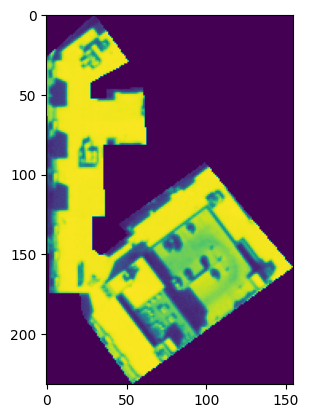

<AxesSubplot: >

In [46]:
show(out_data_band4)

Lets visualise the histogram of the data - we see lots of pixels have nodata value of 0.0

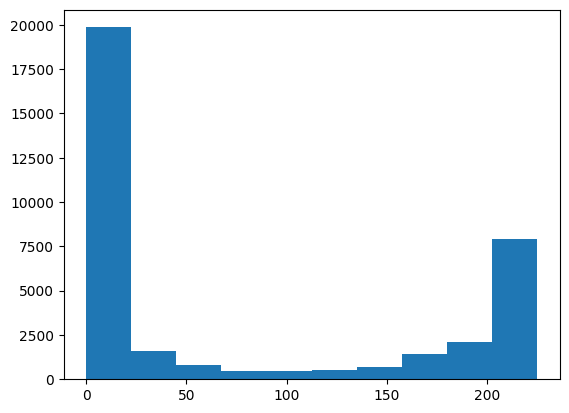

In [47]:
plt.hist(out_data_band4.flatten());

To perform a calculation only on the pixels inside the building we can simply threshold the array:

In [48]:
np.mean(out_data_band4[out_data_band4 > 0.0])

169.82387172661424

You could now iterate over each building in the geodataframe, extract the pixel stats you want, and add this data back to the geodataframe